<a href="https://colab.research.google.com/github/mhuertascompany/DL_ED127_2020/blob/master/tutorials/day1/solutions/Galaxy_Morphology_Deep_RF_solved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Galaxy Morphology with "classical ML" and deep learning

The goal of this tutorial is to illustrate a very basic supervised binary classification with different ML approaches. The goal is to setup a ML algorithm to determine the visual morphological type of nearby galaxies from the Sloan Digital Sky Survey. The first deep learning papers in Astronomy addressed this problem at low and high redshift (Dielemann+15, Huertas-Company+15).

![](https://drive.google.com/uc?id=1TaiRB1wxui4AKnhuF4iH4LJkmrlb-D6d)

The notebook illustrates first how to train a Random Forest and an Artifical Neural Network using catalog parameters (Stellar Mass and Color). The ML models are taken from scikitlearn.

Then we use a Convolutional Neural Network (deep learning) to learn the features directly from the images with no catalog information. The CNN  model is implemented here with Keras and a TensorFlow backend.  We use as training set, the visually classified sample of ~14,000 galaxies by Nair&Abraham. For illustration purposes, we use jpeg RGB images as input. However the same methodology can be applied to fits.

---



#### Before we start, make sure to open this Colab notebook in "PlayGround Mode" (top left) and to change the Runtime type to GPU by navigating to the toolbar and clicking Runtime -> Change runtime type and then changing Hardware accelerator to GPU

---

In [1]:
import numpy as np
from astropy.io import fits
from astropy.table import Table
import os
from sklearn import preprocessing
import pdb
import pickle
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import  BatchNormalization
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import rmsprop
import pdb
import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard

from sklearn.metrics import roc_curve, precision_recall_curve, accuracy_score,auc

%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


## Mount Drive

Before mounting the drive click on [this folder](https://drive.google.com/drive/folders/1PcftgBzBySo1Ync-Wdsp9arTCJ_MfEPE?usp=sharing) and add it to your google drive by following these steps:

*   Go to your drive 
*   Find shared folder ("Shared with me" link)
*   Right click it
*   Click Add to My Drive



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


---
#### The notenook is setup to illustrate 2 different classifications:


#### 1.   Early vs. Late: This is an easy example in which we only try to separate between early-type and late-type galaxies.

#### 2.   E vs. S0: The second example is more challenging. We try to separate ellipticals from S0s.

#### By default case 1 is turn on. In order to switch to case 2 set the variable CLASS_EARLY_LATE to False.

---





In [0]:
CLASS_EARLY_LATE=True

## Classical ML (RF)

### Load data and prepare data

For the classical approaches, the input are catalog parameters (color, mass for illustration) which correlate with galaxy morphology. It is well known that early type galaxies are redder and more massive than late type galaxies. So we are going to exploit these correlation to estimate the galaxy morphology.

In [0]:
pathinData="/content/drive/My Drive/EDE2019/morphology"

if CLASS_EARLY_LATE:
  # donwload feature vector and labels
  X_ML = np.load(pathinData+'/feature_E_S.npy')
  #morphological class
  Y_ML = np.load(pathinData+'/label_E_S.npy') 
  #we also load images (for visualization purposes - not used for training)
  I_ML=np.load(pathinData+'/images_ML.npy') 

  

else:
  # donwload feature vector and labels
  X_ML = np.load(pathinData+'/feature_E_S0.npy')
  #morphological class
  Y_ML = np.load(pathinData+'/label_E_S0.npy') 
  #we also load images (for visualization purposes - not used for training)
  I_ML=np.load(pathinData+'/images_ML_E_S0.npy') 
  
#split training and test datasets
X_ML_train = X_ML[0:len(X_ML)//5*4,:]   
X_ML_test = X_ML[len(X_ML)//5*4:,:]
Y_ML_train = Y_ML[0:len(Y_ML)//5*4]
Y_ML_test = Y_ML[len(Y_ML)//5*4:]
I_ML_train = I_ML[0:len(I_ML)//5*4,:,:,:]
I_ML_test = I_ML[len(Y_ML)//5*4:,:,:,:]


### Visualize some images for illustration

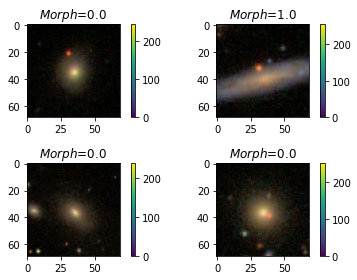

In [5]:
randomized_inds_train = np.random.permutation(len(I_ML))

fig = plt.figure()
for i,j in zip(randomized_inds_train[0:4],range(4)):
  ax = fig.add_subplot(2, 2, j+1)
  im = ax.imshow(I_ML[i,:,:].astype(int))
  plt.title('$Morph$='+str(Y_ML[i]))
  fig.tight_layout() 
  fig.colorbar(im)


### Visualize the feature space used for classification (Stellar Mass / Color)

For the classical ML classification we are going to use 2 catalog parameters only (stellar mass and color). This means that all the information contained in the images is reduced to 2 parameters (features) which is what the algorithms see and will use for classification. The following cell plots these parameters for both classes. The two different classes are expected to have different distributions in the feature space so that the ML algorithm can partition the space.

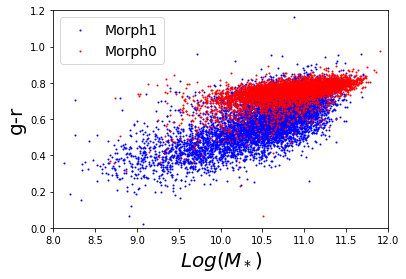

In [6]:
xlabel("$Log(M_*)$", fontsize=20)
ylabel("g-r", fontsize=20)
xlim(8,12)
ylim(0,1.2)
scatter(X_ML[Y_ML==1,1],X_ML[Y_ML==1,0],color='blue',s=1,label='Morph1')
scatter(X_ML[Y_ML==0,1],X_ML[Y_ML==0,0],color='red',s=1,label='Morph0')
legend(fontsize=14)

### Train RF classifier
We firsty train a RF classifier. The classifer takes as input the 2 parameters (Stellar Mass and Color) and tries to predict the visual morphology. We use here a depth of 5 and default settings. You can change the parameters and explore the effects.

In [7]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_ML_train, Y_ML_train)
print("Trained RF Classifier")
print(clf)
print("Importance of each feature")
print(clf.feature_importances_)

Trained RF Classifier
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
Importance of each feature
[0.77436941 0.22563059]


### Visualize a random Tree
The following tree plots a random tree from the trained RF. For an explanation of the different elements in the graph go to this [link](https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76).

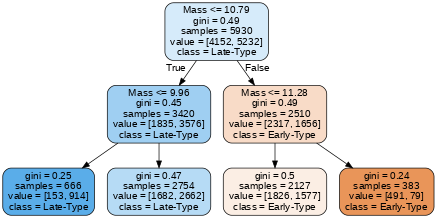

In [8]:
# Extract single tree - this numnber can be changed (< n_estimators)
estimator = clf.estimators_[1]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = ["Color","Mass"],
                class_names = ["Early-Type","Late-Type"],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=50'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

## Predictions and accuracy of classification
The following cells use the trained model  to predict the morphological class of the test dataset and assess the performance of the classification. 

In [10]:
print("Predicting...")
print("====================")


Y_pred_RF=clf.predict_proba(X_ML_test)[:,1]
print(Y_pred_RF.shape)



Predicting...
(2349,)


We now compute the global accuracy as well as ROC and P-R curves. If you are not familiar with these curves please see the lecture slides or click [here](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) 

Global Accuracy RF: 0.8054491272882077
AUC RF: 0.8681733069029575


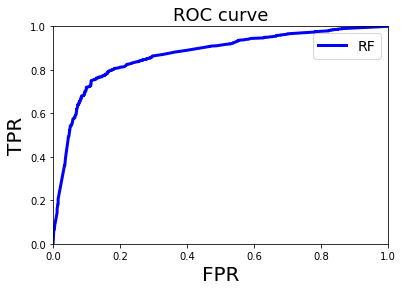

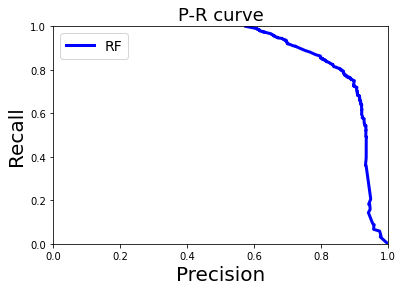

In [11]:
#global accuracy

Y_pred_RF_class=Y_pred_RF*0
Y_pred_RF_class[Y_pred_RF>0.5]=1




print("Global Accuracy RF:", accuracy_score(Y_ML_test, Y_pred_RF_class))





# ROC curve (False positive rate vs. True positive rate)

fpr_RF, tpr_RF, thresholds_RF = roc_curve(Y_ML_test, Y_pred_RF)


print("AUC RF:", auc(fpr_RF, tpr_RF))


#plot ROC
fig = plt.figure() 
title('ROC curve',fontsize=18)
xlabel("FPR", fontsize=20)
ylabel("TPR", fontsize=20)
xlim(0,1)
ylim(0,1)
plot(fpr_RF,tpr_RF,linewidth=3,color='blue',label='RF')
legend(fontsize=14)


# Precision Recall curve (False positive rate vs. True positive rate)
precision_RF, recall_RF, thresholds_RF = precision_recall_curve(Y_ML_test, Y_pred_RF)
#plot PR curve
fig = plt.figure() 
title('P-R curve',fontsize=18)
xlabel("Precision", fontsize=20)
ylabel("Recall", fontsize=20)
xlim(0,1)
ylim(0,1)
plot(precision_RF,recall_RF,linewidth=3,color='blue',label='RF')
legend(fontsize=14)

The follwing cells visualize some random examples of bad classifications in order to explore what the network has understood. If you run multiple times the examples will change.

### Bad classifcations of RFs

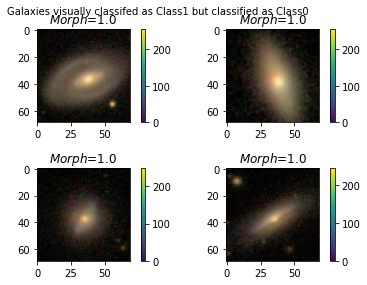

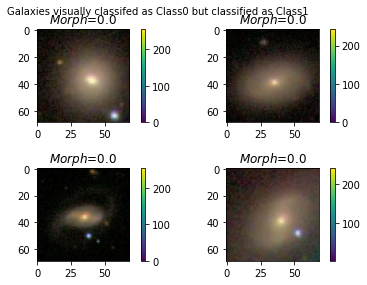

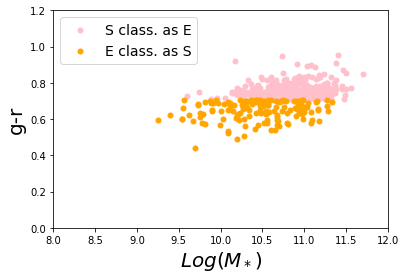

In [12]:
# objects classifed as early-types by the RF but visually classifed as late-types
bad = np.where((Y_pred_RF<0.5)&(Y_ML_test==1))
randomized_inds_train = np.random.permutation(bad)

fig = plt.figure()
fig.suptitle("Galaxies visually classifed as Class1 but classified as Class0",fontsize=10)
for i,j in zip(randomized_inds_train[0][0:4],range(4)):
  ax = fig.add_subplot(2, 2, j+1)
  im = ax.imshow(I_ML_test[i,:,:])
  plt.title('$Morph$='+str(Y_ML_test[i]))
  fig.tight_layout() 
  fig.colorbar(im)



# objects classifed as late-types by the CNN but visually classifed as early-types
bad2 = np.where((Y_pred_RF>0.5)&(Y_ML_test==0))
randomized_inds_train = np.random.permutation(bad2)

fig = plt.figure()
fig.suptitle("Galaxies visually classifed as Class0 but classified as Class1",fontsize=10)
for i,j in zip(randomized_inds_train[0][0:4],range(4)):
  ax = fig.add_subplot(2, 2, j+1)
  im = ax.imshow(I_ML_test[i,:,:])
  plt.title('$Morph$='+str(Y_ML_test[i]))
  fig.tight_layout() 
  fig.colorbar(im)
  
#visualize the feature space
fig = plt.figure()
xlabel("$Log(M_*)$", fontsize=20)
ylabel("g-r", fontsize=20)
xlim(8,12)
ylim(0,1.2)
scatter(X_ML_test[bad[0],1],X_ML_test[bad[0],0],color='pink',s=25,label="S class. as E")
scatter(X_ML_test[bad2[0],1],X_ML_test[bad2[0],0],color='orange',s=25,label='E class. as S') 
legend(fontsize=14)